## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

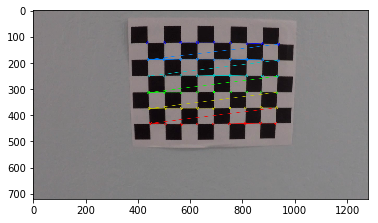

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        plt.imshow(img)

In [2]:
img = cv2.imread('./camera_cal/calibration1.jpg')



## And so on and so forth...

In [3]:
image_size = img.shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,(img.shape[1], img.shape[0]),None,None)

def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


Text(0.5,1,'Undistorted Images')

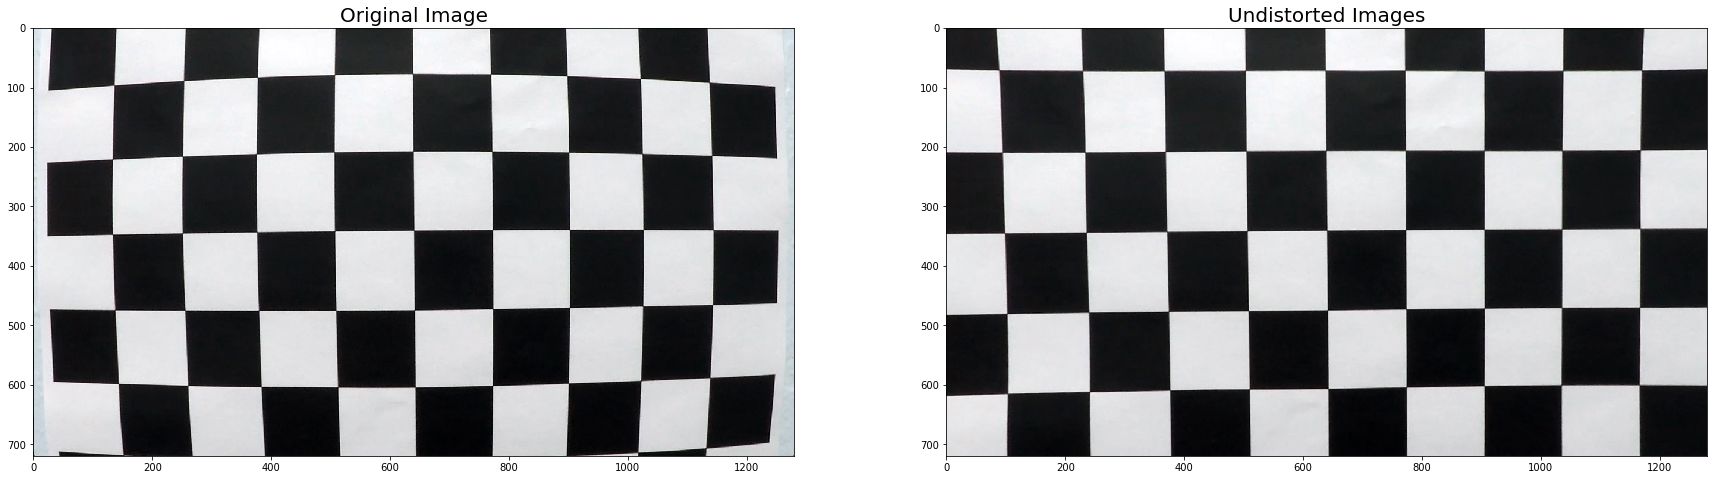

In [4]:

undistorted = cal_undistort(img)
f, axes= plt.subplots(1,2,figsize=(30,30))


axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=20)
axes[1].imshow(undistorted)
axes[1].set_title("Undistorted Images", fontsize=20)


In [51]:
#Useful Helper Functions 

def abs_sobel_thresh(img, orient, thresh_min=0, thresh_max=255): 

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(graddir)
    # 6) Return this mask as your binary_output image
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary_output


def color_threshold(img, s_thresh=(0, 255),v_thresh=(0,255)):
   
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_channel = hls [:,:,2]
    # 2) Apply a threshold to the S channel
    s_binary = np.zeros_like(s_channel)
    
    s_binary[(s_channel> s_thresh[0]) & (s_channel <= s_thresh[1])]=1
    
     # 3) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel>=v_thresh[0]) & (v_channel<=v_thresh[1])] = 1   
    
    output= np.zeros_like(s_channel)
    output[(s_binary==1) & (v_binary==1)] = 1
    
    return output 

def src_dst(img):
    img_width = img.shape[1]
    img_height= img.shape[0]
    
    bot_width = .76 
    mid_width = .17 
    height_pct = .66 
    bottom_trim = .97
    src = np.float32([
        [img_width*0.43, img_height*height_pct],
        [img_width*0.59, img_height*height_pct],
        [img_width*0.9, img_height*bottom_trim],
        [img_width*0.23, img_height*bottom_trim]
    ])
    
    offset = img_width*.2
    
    dst = np.float32([
        [offset, 0],
        [img_width-offset, 0],
        [img_width-offset, img_height],
        [offset, img_height]])
        
    return src,dst;

def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current -margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ###  Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fit, right_fit, ploty


def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ###Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
   

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,right_fitx,left_fitx

def DrawLine(original_image,preprocessed_image,left_fit, right_fit):
    
    binary_warped = warper(preprocessed_image,src,dst)
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
   
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    
    result = text_info(result,left_curverad, right_curverad, offset_center)
    
    return result


def measure_curvature_real(ploty,left_fitx,right_fitx,image):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    y_eval = np.max(ploty * ym_per_pix)

    # Fit a second order polynomial to pixel positions in each fake lane line
    
    left_fit_cr = np.polyfit (ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit (ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    #####Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    lane_center = (left_fitx[-1] + right_fitx[-1])/2.0
    camera_center = image.shape[1]/2.0
    offset_center = (lane_center - camera_center) * xm_per_pix
    
    return left_curverad, right_curverad, offset_center


def text_info(image,left_curverad, right_curverad, offset_center):
    
    ## copy area image
    final_img = np.copy(image)
    
    ## format text for overlay
    left_text = "Left Curve Radius: {0:.2f}m".format(left_curverad)
    right_text = "Right Curve Radius: {0:.2f}m".format(right_curverad)
    dist_text = "Distance from Center: {0:.2f}m".format(offset_center)
    
    ## area_img writing
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_img, str(left_text), (60,90), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(final_img, str(right_text), (60,140), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(final_img, str(dist_text), (60,190), font, 1.25, (255,255,255), 2, cv2.LINE_AA)

    return final_img



Pipeline 

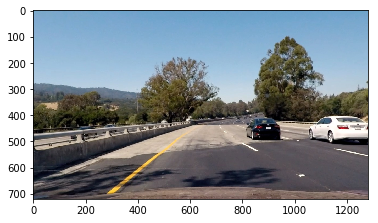

In [52]:
#reading in an image
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
img1 = mpimg.imread('test_images/test4.jpg')
undistorted = cal_undistort(img1)
plt.imshow(undistorted)

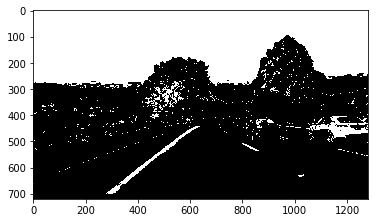

In [53]:
#pipeline 
ksize =5

gradx = abs_sobel_thresh(undistorted, orient='x', thresh_min=50, thresh_max=255)
grady = abs_sobel_thresh(undistorted, orient='y', thresh_min=30, thresh_max=255)

mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(20,100))

dir_binary = dir_threshold (undistorted, sobel_kernel = ksize, thresh=(0.2,np.pi/2))

combined = np.zeros_like(dir_binary)
combined [((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

preprocessed_image = np.zeros_like(undistorted[:,:,0])
C_binary = color_threshold(undistorted, s_thresh=(100,255),v_thresh=(60,255))
preprocessed_image[((gradx == 1) & (grady == 1))|(C_binary==1)]=255

plt.imshow(preprocessed_image, cmap='gray')





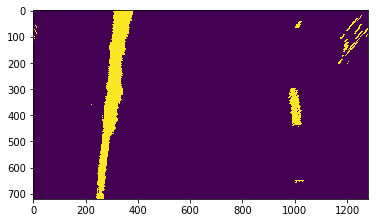

In [54]:
src,dst = src_dst(undistorted)

src= src.reshape(-1,1,2)
dst = dst.reshape(-1,1,2)

warped = warper(preprocessed_image,src,dst)

plt.imshow (warped)

In [55]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)


In [56]:
out_img,left_fit,right_fit,ploty= fit_polynomial (warped)


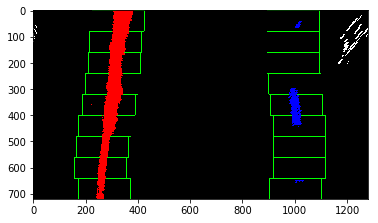

In [57]:
plt.imshow(out_img)

In [58]:
result,left_fitx,right_fitx= search_around_poly(warped,left_fit,right_fit)

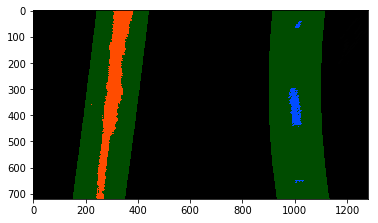

In [59]:
plt.imshow(result)

In [60]:
left_curverad, right_curverad,offset_center = measure_curvature_real(ploty,left_fitx,right_fitx,result)

In [61]:
print(left_curverad, 'm', right_curverad, 'm', offset_center, 'm')


918.096818435 m 12788.6007981 m 0.00953549968037 m


In [62]:
end_image=DrawLine(img1,warped,left_fit,right_fit)

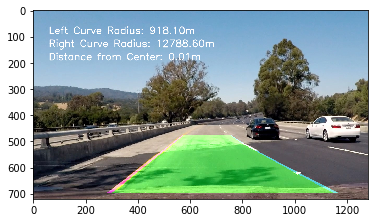

In [63]:
plt.imshow(end_image)

Pipeline

In [64]:


def process_pipeline(image):
    
    undistorted = cal_undistort(image)
    
    ksize =5

    gradx = abs_sobel_thresh(undistorted, orient='x', thresh_min=50, thresh_max=255)
    grady = abs_sobel_thresh(undistorted, orient='y', thresh_min=30, thresh_max=255)

    mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(20,100))

    dir_binary = dir_threshold (undistorted, sobel_kernel = ksize, thresh=(0.2,np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined [((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    preprocessed_image = np.zeros_like(undistorted[:,:,0])
    C_binary = color_threshold(undistorted, s_thresh=(100,255),v_thresh=(60,255))
    preprocessed_image[((gradx == 1) & (grady == 1))|(C_binary==1)]=255

    #plt.imshow(preprocessed_image, cmap='gray')
    
    src,dst = src_dst(undistorted)
        
    src = src.reshape(-1,1,2)
    dst = dst.reshape(-1,1,2)

#     src= np.float32(
#         [[220,707],
#          [597,448],
#          [680,448],
#         [1091,707]])

#     dst= np.float32(
#         [[320,707],
#         [320,10],
#         [970,10] ,
#         [970,707]])  

    warped = warper(preprocessed_image,src,dst)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    out_img,left_fit,right_fit,ploty= fit_polynomial (warped)
    
    left_curverad, right_curverad,offset_center = measure_curvature_real(ploty,left_fitx,right_fitx,out_img)
    
    end_image= DrawLine(image,preprocessed_image,left_fit,right_fit)
    
    #final_image= text_info(end_image,left_curverad, right_curverad, offset_center)
    
    return end_image
    

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

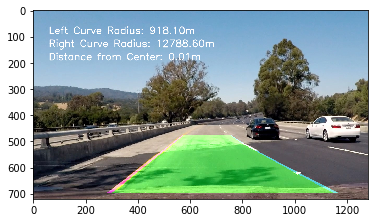

In [66]:
image111= process_pipeline(img1)
plt.imshow(image111)

In [67]:
output = 'preoject_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,8)
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video preoject_video_output.mp4
[MoviePy] Writing video preoject_video_output.mp4


100%|█████████▉| 200/201 [01:04<00:00,  2.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: preoject_video_output.mp4 

CPU times: user 43 s, sys: 5.93 s, total: 48.9 s
Wall time: 1min 7s


In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))